In [1]:
import copy
import pickle
import inspect
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from rich import progress
from scipy import constants

from centrex_tlf import hamiltonian, states
from centrex_trajectories import (
    Coordinates,
    Gravity,
    PropagationOptions,
    PropagationType,
    Velocities,
    propagate_trajectories,
)
from centrex_trajectories.beamline_objects import (
    Bore,
    CircularAperture,
    ElectrostaticLensPolynomial,
    ElectrostaticQuadrupoleLens,
    RectangularAperture,
    Section,
)
from centrex_trajectories.particles import TlF
from centrex_trajectories.utils import (
    double_richards_symmetric,
    fit_stark_potential,
)
from centrex_trajectories.polynomials import Polynomial2D
from centrex_trajectories.visualization import plot_beamline
from eigenshuffle import eigenshuffle_eigh

In [2]:
plt.rcParams.update({"font.size": 14})

In [3]:
class TaskSpeed(progress.ProgressColumn):
    def render(self, task):
        if task.speed is None:
            return ""
        elif task.speed >= 0.1:
            return f"{(task.speed or 0):.1f}/s"
        else:
            return f"{(1 / task.speed or 0):.1f} s/i"

# Setup
## Generate Stark Potentials

In [4]:
# generate states up to J=6
QN = states.generate_uncoupled_states_ground(Js=np.arange(7))

# generate the X hamiltonian terms
H = hamiltonian.generate_uncoupled_hamiltonian_X(QN)

# create a function outputting the hamiltonian as a function of E and B
Hfunc = hamiltonian.generate_uncoupled_hamiltonian_X_function(H)

# V/cm
Ez = np.linspace(0, 50e3, 2_001)

# generate the Hamiltonian for (almost) zero field, add a small field to make states
# non-degenerate
Hi = Hfunc(E=[0, 0, 1e-3], B=[0, 0, 1e-3])
E, V = np.linalg.eigh(Hi)

# run eigenshuffle to track the states
Ez = np.append(np.linspace(0, 1_000, 501), np.linspace(2_000, 50_000, 51))
hamiltonians = np.array([Hfunc(E=[0, 0, Ei], B=[0, 0, 1e-3]) for Ei in Ez])
es, vs = eigenshuffle_eigh(hamiltonians)

# get the true superposition-states of the system
QN_states = hamiltonian.matrix_to_states(vs[0], QN)

In [5]:
indices_J2 = [idx for idx, s in enumerate(QN_states) if s.largest.J == 2]

indices_J2_F3 = (
    indices_J2[0]
    + np.where(
        [
            qn.largest.F == 3
            for qn in [
                qn.remove_small_components().transform_to_coupled()
                for qn in np.array(QN_states)[indices_J2]
            ]
        ]
    )[0]
)
indices_J2_other = [idx for idx in indices_J2 if idx not in indices_J2_F3]

indices_J2_mF0 = (
    indices_J2[0]
    + np.where(
        [
            qn.largest.mF == 0 and qn.largest.F == 3
            for qn in [
                qn.remove_small_components().transform_to_coupled()
                for qn in np.array(QN_states)[indices_J2]
            ]
        ]
    )[0]
)

indices_J2_mF2 = (
    indices_J2[0]
    + np.where(
        [
            qn.largest.mF == 2 and qn.largest.F == 3
            for qn in [
                qn.remove_small_components().transform_to_coupled()
                for qn in np.array(QN_states)[indices_J2]
            ]
        ]
    )[0]
)

indices_J2_mF3 = (
    indices_J2[0]
    + np.where(
        [
            qn.largest.mF == 3
            for qn in [
                qn.remove_small_components().transform_to_coupled()
                for qn in np.array(QN_states)[indices_J2]
            ]
        ]
    )[0]
)

In [6]:
# convert to V/m
Ez_Vm = Ez * 100

# grab energy of J=2, mF=0, 2 & 3
# mF=-1,0,1 have more or less the same energy levels, just slight differences at higher
# fields
energy = es.real[:, indices_J2_mF0[0]] * constants.hbar
fit_coeff_mF0 = fit_stark_potential(Ez_Vm, energy, deg=11)

energy = es.real[:, indices_J2_mF2[0]] * constants.hbar
fit_coeff_mF2 = fit_stark_potential(Ez_Vm, energy, deg=11)

energy = es.real[:, indices_J2_mF3[0]] * constants.hbar
fit_coeff_mF3 = fit_stark_potential(Ez_Vm, energy, deg=11)

## Beamline Setup

In [7]:
options = PropagationOptions(verbose=False, n_cores=8)
particle = TlF()
gravity = Gravity(0, -9.81 * particle.mass, 0)

# EQL parameters
L = 0.6
R = 1.75 * 25.4e-3 / 2
V = 28_000


# DET parameters current aperture
wx = 13e-3
wy = 3e-3

# conversion factors
in_to_m = 25.4e-3

n_nipples = 3

# beamline lengths
distance_lens_bbexit = 36 * in_to_m
lens_chamber_length = (24 + 5 / 8) * in_to_m
lens_reducer_flange = (7 / 8 + 3 + 1 / 8) * in_to_m
lens_electrode_length = L  # m
nipple_length = 39 * in_to_m
distance_det_center = 5.25 * in_to_m
lens_reducer_flange = (3 + 1 / 8 + 7 / 8) * in_to_m
bs_flange = 3 / 4 * in_to_m
rc_chamber_length_no_flanges = 10.5 * in_to_m
rc_chamber_center_from_bs_front = (16 + 3 / 8) * in_to_m
rc_aperture_from_center = 3.56 * in_to_m
rc_aperture_radius = 0.011


# acme freezing distribution modified to our cell opening size (0.25" vs 5 mm for ACME)
sigma_x = 0.25 * 25.4 / 5 * 3.8e-3  # Sigma for the gaussian position distribution
sigma_y = sigma_x


In [8]:
potential_xy_coefficients = np.array(
    [
        [
            0.00000000e00,
            0.00000000e00,
            -1.85807316e-03,
            -3.68838654e-01,
            9.05179603e01,
            5.02802652e02,
            -2.33774653e05,
        ],
        [
            0.00000000e00,
            -4.01516882e03,
            -4.57787118e-02,
            -8.53726662e03,
            -9.44499189e03,
            5.34213172e08,
            2.04894221e07,
        ],
        [
            1.55556469e-02,
            -1.08269983e01,
            4.98195718e02,
            1.21401040e05,
            -6.62042908e06,
            -2.00043668e08,
            1.63384388e10,
        ],
        [
            4.95047018e-01,
            -8.94339785e03,
            1.44796476e04,
            -1.69855041e09,
            -6.86084354e07,
            -6.47064425e09,
            -2.57901217e04,
        ],
        [
            -1.83341406e02,
            4.73566410e04,
            2.21617329e06,
            -3.02270553e08,
            -7.46259863e09,
            -1.14022371e05,
            -3.74750620e05,
        ],
        [
            -1.83757741e03,
            5.34389645e08,
            -1.65987718e07,
            6.46968544e09,
            -2.13239592e04,
            -1.31548209e02,
            -7.07835673e00,
        ],
        [
            2.78503072e05,
            -4.15374780e07,
            -1.08606156e09,
            -1.22530620e05,
            -2.91966193e06,
            -3.60532824e01,
            -5.51716726e02,
        ],
    ]
)

args_double_richards = [
    np.float64(-0.2772285477882198),
    np.float64(0.2772285477882198),
    np.float64(0.0),
    np.float64(1.0),
    np.float64(0.17549989486349324),
    np.float64(199.16917527732758),
    np.float64(3.3589614392622846),
]

signature = inspect.signature(double_richards_symmetric)
arg_names = [param.name for param in signature.parameters.values()]

potential_z = partial(
    double_richards_symmetric,
    **dict([(name, arg) for name, arg in zip(arg_names[1:], args_double_richards)]),
)


## Beamline Sections

| What | Length |
| --- | --- |  
| bs flange | 3/4" |
| center of the RC chamber to the beamsource front | 16-3/8" |
| center of the SPA chamber to the beamsource front | 28-3/8" |
| front of the EQL chamber to the beamsource front | 36" |
| lens chamber length | 24-5/8" |
| lens electrode length | 0.6 m |
| lens flange with o-ring | 7/8" |
| lens reducer | 3-1/8" |
| center of DET to start chamber | 5-1/4" |
| long nipple length | 39" |
| rc chamber length without flanges | 10.5" |
| rc chamber front without flanges to front bs flange | 10-3/8" |
| rc aperture from center rc | 3.56" | 
| rc aperture radius | 0.011 m |

In [9]:
fourK = Section(
    name="4K shield",
    objects=[CircularAperture(0, 0, 1.75 * in_to_m, in_to_m / 2)],
    start=0,
    stop=(1.75 + 0.25) * 0.0254,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)
fourtyK = Section(
    name="40K shield",
    objects=[CircularAperture(0, 0, fourK.stop + 1.25 * in_to_m, in_to_m / 2)],
    start=fourK.stop,
    stop=fourK.stop + (1.25 + 0.25) * 0.0254,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)
bbexit = Section(
    name="Beamsource Exit",
    objects=[CircularAperture(0, 0, fourtyK.stop + 2.5 * in_to_m, 2 * in_to_m)],
    start=fourtyK.stop,
    stop=fourtyK.stop + (2.5 + 0.75) * in_to_m,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)

rc = Section(
    name="Rotational cooling",
    objects=[
        CircularAperture(
            x=0,
            y=0,
            z=bbexit.stop + rc_chamber_center_from_bs_front + rc_aperture_from_center,
            r=rc_aperture_radius,
        )
    ],
    start=bbexit.stop
    + bs_flange
    + rc_chamber_center_from_bs_front
    - rc_chamber_length_no_flanges / 2,
    stop=bbexit.stop
    + rc_chamber_center_from_bs_front
    + rc_chamber_length_no_flanges / 2,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)

spa = Section(
    name="State Prep A",
    objects=[],
    start=bbexit.stop,
    stop=bbexit.stop + (19.6 + 0.375 + 9.625 + 0.375) * in_to_m,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)

lens_start = (
    bbexit.stop
    + distance_lens_bbexit
    + (lens_chamber_length - lens_electrode_length) / 2
)

lens_stop = lens_start + lens_electrode_length

lens_middle = (lens_start + lens_stop) / 2

eql = ElectrostaticLensPolynomial(
    name="Electrostatic Lens",
    objects=[
        Bore(
            x=0,
            y=0,
            z=bbexit.stop
            + distance_lens_bbexit
            + (lens_chamber_length - lens_electrode_length) / 2,
            length=lens_electrode_length,
            radius=R,
        )
    ],
    start=lens_start,
    stop=lens_stop,
    V=V,
    R=R,
    save_collisions=True,
    potential_xy=Polynomial2D(kx=6, ky=6, coeffs=potential_xy_coefficients),
    potential_z=lambda z: potential_z(z - lens_middle),
)

det_start = (
    eql.stop
    + (lens_chamber_length - lens_electrode_length) / 2
    + lens_reducer_flange
    + n_nipples * nipple_length
    + 10.5 * in_to_m
    + distance_det_center
)
det_stop = (
    eql.stop
    + (lens_chamber_length - lens_electrode_length) / 2
    + lens_reducer_flange
    + n_nipples * nipple_length
    + 10.5 * in_to_m
    + distance_det_center
    + 1e-2
)

det = Section(
    name="Detection",
    objects=[
        RectangularAperture(
            0,
            0,
            det_start,
            wx,
            wy,
        )
    ],
    start=det_start,
    stop=det_stop,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
    force=None,
)


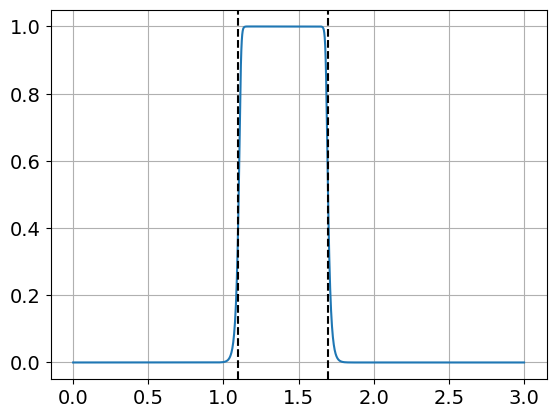

In [10]:
z = np.linspace(0, 3, 1001)
fig, ax = plt.subplots()
ax.plot(z, eql.potential_z(z))
ax.axvline(eql.start, color="k", linestyle="--")
ax.axvline(eql.stop, color="k", linestyle="--")
ax.grid()

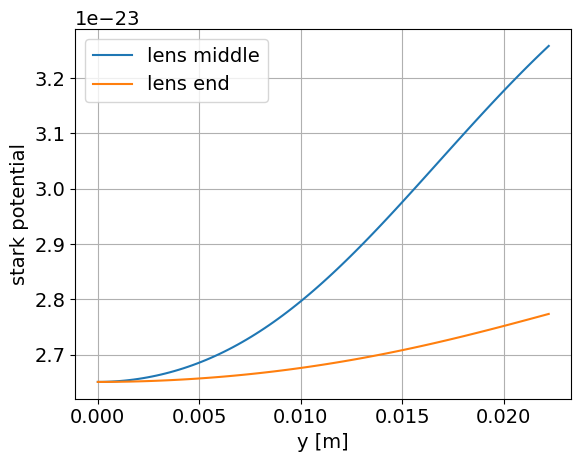

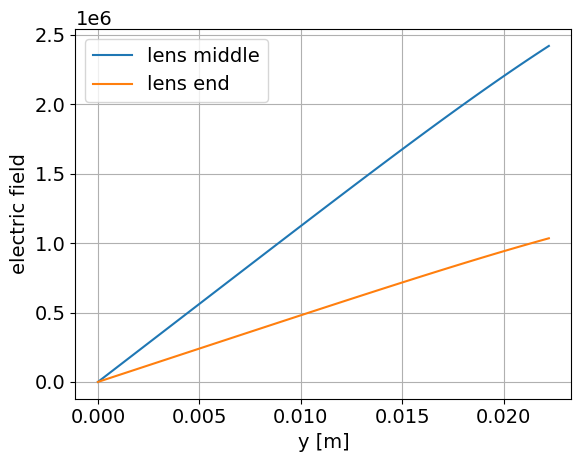

In [11]:
_r = np.linspace(0, R, 101)

fig, ax = plt.subplots()
ax.plot(
    _r,
    eql.stark_potential(np.zeros(_r.shape), _r, np.ones(_r.shape) * lens_middle),
    label="lens middle",
)
ax.plot(
    _r,
    eql.stark_potential(np.zeros(_r.shape), _r, np.ones(_r.shape) * eql.stop),
    label="lens end",
)

ax.set_ylabel("stark potential")
ax.set_xlabel("y [m]")
ax.legend()

ax.grid(True)

fig, ax = plt.subplots()

ax.plot(
    _r,
    np.linalg.norm(
        eql.electric_field(np.zeros(_r.shape), _r, np.ones(_r.shape) * lens_middle),
        axis=0,
    ),
    label="lens middle",
)
ax.plot(
    _r,
    np.linalg.norm(
        eql.electric_field(np.zeros(_r.shape), _r, np.ones(_r.shape) * eql.stop),
        axis=0,
    ),
    label="lens end",
)

ax.set_ylabel("electric field")
ax.set_xlabel("y [m]")
ax.legend()

ax.grid(True)

In [36]:
def lens_scan_function(
    origin: Coordinates,
    velocities: Velocities,
    voltage: float,
    detection_laser_distance: float,
    detection_aperture_distance: float,
    length: float = 0.6,
    radius: float = 0.022225,
    stark_potential: npt.NDArray[np.float64] = fit_coeff_mF0,
    ideal_lens: bool = False,
):
    lens_start = bbexit.stop + distance_lens_bbexit + (lens_chamber_length - length) / 2
    lens_stop = lens_start + length
    lens_middle = (lens_start + lens_stop) / 2

    if voltage == 0:
        eql = Section(
            name="Electrostatic Lens",
            objects=[
                Bore(
                    x=0,
                    y=0,
                    z=lens_start,
                    length=length,
                    radius=radius,
                )
            ],
            start=lens_start,
            stop=lens_stop,
            save_collisions=False,
        )
    else:
        if ideal_lens:
            eql = ElectrostaticQuadrupoleLens(
                name="Electrostatic Lens",
                objects=[Bore(x=0, y=0, z=lens_start, length=length, radius=radius)],
                start=lens_start,
                stop=lens_stop,
                V=voltage,
                R=radius,
                save_collisions=False,
                stark_potential=stark_potential,
            )
        else:
            eql = ElectrostaticLensPolynomial(
                name="Electrostatic Lens",
                objects=[
                    Bore(
                        x=0,
                        y=0,
                        z=lens_start,
                        length=length,
                        radius=radius,
                    )
                ],
                start=lens_start,
                stop=lens_stop,
                V=voltage,
                R=radius,
                save_collisions=False,
                stark_potential=stark_potential,
                potential_xy=Polynomial2D(kx=6, ky=6, coeffs=potential_xy_coefficients),
                potential_z=lambda z: potential_z(z - lens_middle),
            )
    det_start = (
        eql.stop + (lens_chamber_length - length) / 2 + detection_aperture_distance
    )
    det_stop = det_start + (detection_laser_distance - detection_aperture_distance)
    det = Section(
        name="Detection",
        objects=[
            RectangularAperture(
                0,
                0,
                det_start,
                wx,
                wy,
            )
        ],
        start=det_start - 1e-3,
        stop=det_stop,
        save_collisions=False,
        propagation_type=PropagationType.ballistic,
        force=None,
    )

    sections = [eql, det]
    section_data, trajectories = propagate_trajectories(
        sections,
        origin,
        velocities,
        particle,
        force=gravity,
        options=options,
    )
    return section_data, trajectories, sections


## Initialize distribution

In [13]:
n_trajectories = 40_000_000

origin = Coordinates(
    x=np.random.randn(n_trajectories) * sigma_x,
    y=np.random.randn(n_trajectories) * sigma_y,
    z=np.zeros(n_trajectories),
)
velocities = Velocities(
    vx=np.random.randn(n_trajectories) * 39.4,
    vy=np.random.randn(n_trajectories) * 39.4,
    vz=np.random.randn(n_trajectories) * 16 + 184,
)

# Scan

## Pre-propagate

In [ ]:
sections = [fourK, fourtyK, bbexit, rc, spa]
section_data_prepropagate, trajectories_prepropagate = propagate_trajectories(
    sections,
    origin,
    velocities,
    particle,
    force=gravity,
    options=options,
)


In [37]:
origin_prepropagate, velocities_prepropagate = (
    trajectories_prepropagate.get_coordinates_velocities_at_position(z=spa.stop)
)


In [ ]:
voltages = (
    np.array(
        [0.0, 10.0, 15.0, 20.0, 21.25, 22.5, 23.75, 25.0, 26.25, 27.5, 28.75, 30.0]
    )
    * 1e3
)

data = {"mF=0": [], "mF=2": [], "mF=3": []}

with progress.Progress(
    progress.TextColumn("[progress.description]{task.description}"),
    progress.BarColumn(),
    progress.TaskProgressColumn(),
    progress.MofNCompleteColumn(),
    progress.TimeElapsedColumn(),
    progress.TimeRemainingColumn(),
) as pb:
    t2 = pb.add_task("mF", total=3)
    t3 = pb.add_task("voltage", total=len(voltages))
    for idx, (mf, stark_coeff) in enumerate(
        zip(["mF=0", "mF=2", "mF=3"], [fit_coeff_mF0, fit_coeff_mF2, fit_coeff_mF3])
    ):
        for idy, voltage in enumerate(voltages):
            det_laser_distance = (
                lens_reducer_flange
                + n_nipples * nipple_length
                + 10.5 * in_to_m
                + distance_det_center
            )
            det_aperture_distance = det_laser_distance - 1 * in_to_m
            data[mf].append(
                lens_scan_function(
                    origin_prepropagate,
                    velocities_prepropagate,
                    voltage,
                    detection_laser_distance=det_laser_distance,
                    detection_aperture_distance=det_aperture_distance,
                    length=lens_electrode_length,
                    stark_potential=stark_coeff,
                )
            )
            pb.update(task_id=t3, completed=idy + 1, refresh=True)
        pb.update(task_id=t2, completed=idx + 1, refresh=True)
        pb.refresh()


Output()

In [39]:
voltages = (
    np.array(
        [0.0, 10.0, 15.0, 20.0, 21.25, 22.5, 23.75, 25.0, 26.25, 27.5, 28.75, 30.0]
    )
    * 1e3
)

data_ideal = {"mF=0": [], "mF=2": [], "mF=3": []}

with progress.Progress(
    progress.TextColumn("[progress.description]{task.description}"),
    progress.BarColumn(),
    progress.TaskProgressColumn(),
    progress.MofNCompleteColumn(),
    progress.TimeElapsedColumn(),
    progress.TimeRemainingColumn(),
) as pb:
    t2 = pb.add_task("mF", total=3)
    t3 = pb.add_task("voltage", total=len(voltages))
    for idx, (mf, stark_coeff) in enumerate(
        zip(["mF=0", "mF=2", "mF=3"], [fit_coeff_mF0, fit_coeff_mF2, fit_coeff_mF3])
    ):
        for idy, voltage in enumerate(voltages):
            data_ideal[mf].append(
                lens_scan_function(
                    origin_prepropagate,
                    velocities_prepropagate,
                    voltage,
                    detection_laser_distance=lens_reducer_flange
                    + n_nipples * nipple_length
                    + 10.5 * in_to_m
                    + distance_det_center,
                    detection_aperture_distance=lens_reducer_flange
                    + n_nipples * nipple_length
                    + distance_det_center
                    + 10.5 * in_to_m
                    - 1 * in_to_m,
                    length=lens_electrode_length,
                    stark_potential=stark_coeff,
                    ideal_lens=True,
                )
            )
            pb.update(task_id=t3, completed=idy + 1, refresh=True)
        pb.update(task_id=t2, completed=idx + 1, refresh=True)
        pb.refresh()

Output()

# Visualization

## Average over states

In [40]:
from centrex_tlf.utils import population

In [41]:
survived = {
    "mF=0": np.array([], dtype=np.int64),
    "mF=2": np.array([], dtype=np.int64),
    "mF=3": np.array([], dtype=np.int64),
}
survived_ideal = {
    "mF=0": np.array([], dtype=np.int64),
    "mF=2": np.array([], dtype=np.int64),
    "mF=3": np.array([], dtype=np.int64),
}
for mf in ["mF=0", "mF=2", "mF=3"]:
    survived[mf] = np.array([len(d[1]) for d in data[mf]])
    survived_ideal[mf] = np.array([len(d[1]) for d in data_ideal[mf]])


In [42]:
print(f"{survived=}")
print(f"{survived_ideal=}")


survived={'mF=0': array([ 206,  290,  494, 1210, 1645, 2088, 2464, 2688, 2814, 2654, 2485,
       2113]), 'mF=2': array([206, 243, 283, 356, 359, 376, 389, 414, 444, 443, 463, 468]), 'mF=3': array([206, 159, 109,  62,  51,  39,  37,  41,  35,  37,  33,  26])}
survived_ideal={'mF=0': array([ 206,  290,  496, 1381, 1824, 2274, 2684, 2787, 2784, 2630, 2316,
       2031]), 'mF=2': array([206, 247, 295, 357, 366, 382, 408, 436, 449, 461, 468, 481]), 'mF=3': array([206, 157, 105,  56,  46,  39,  37,  37,  38,  36,  28,  27])}


In [43]:
temperature = 6.3
rc_efficiency = 0.8
thermal_population = population.thermal_population(np.arange(4), temperature)

rc_population = (
    3 / 4 * thermal_population[0] + rc_efficiency * thermal_population[1:].sum()
)

J2_levels = population.J_levels(2)

survived_avg = (
    survived["mF=0"] * rc_population
    + (survived["mF=2"] + survived["mF=3"])
    * (1 - rc_efficiency)
    * thermal_population[2]
    * 4
    / J2_levels
)
b = (1 - rc_efficiency) * thermal_population[2] * 2 / J2_levels

sigma_survived_avg = np.sqrt(
    rc_population**2 * survived["mF=0"] + b**2 * (survived["mF=2"] + survived["mF=3"])
)


survived_ideal_avg = (
    survived_ideal["mF=0"] * rc_population
    + survived_ideal["mF=2"]
    * (1 - rc_efficiency)
    * thermal_population[2]
    * 2
    / J2_levels
    + survived_ideal["mF=3"]
    * (1 - rc_efficiency)
    * thermal_population[2]
    * 2
    / J2_levels
)

sigma_survived_ideal_avg = np.sqrt(
    rc_population**2 * survived_ideal["mF=0"]
    + b**2 * (survived_ideal["mF=2"] + survived_ideal["mF=3"])
)


gains = survived_avg / survived_avg[0]
gains_error = gains * np.sqrt(
    (sigma_survived_avg / survived_avg) ** 2
    + (sigma_survived_avg[0] / survived_avg[0]) ** 2
)

gains_ideal = survived_ideal_avg / survived_ideal_avg[0]
gains_error_ideal = gains_ideal * np.sqrt(
    (sigma_survived_ideal_avg / survived_ideal_avg) ** 2
    + (sigma_survived_ideal_avg[0] / survived_ideal_avg[0]) ** 2
)


In [44]:
print(f"{survived_avg=}")
print(f"{sigma_survived_avg=}")
print(f"{survived_ideal_avg=}")
print(f"{sigma_survived_ideal_avg=}")
print(f"{gains=}")
print(f"{gains_error=}")
print(f"{gains_ideal=}")
print(f"{gains_error_ideal=}")


survived_avg=array([  94.70846109,  132.01669447,  222.72760077,  541.55500727,
        735.08078652,  932.26247295, 1099.67184961, 1199.57038837,
       1255.81992539, 1184.62372525, 1109.53278115,  943.96976751])
sigma_survived_avg=array([ 6.38770844,  7.57881579,  9.89138299, 15.48030699, 18.0496342 ,
       20.33527034, 22.09045548, 23.07272539, 23.60730036, 22.92634886,
       22.1844115 , 20.45667157])
survived_ideal_avg=array([  93.19152482,  130.5439408 ,  222.2038018 ,  616.09637921,
        813.23756491, 1013.53072538, 1196.07822314, 1242.01861016,
       1240.73508972, 1172.23847829, 1032.49780222,  905.71063661])
sigma_survived_ideal_avg=array([ 6.38770844,  7.57881758,  9.91139019, 16.53800175, 19.00629752,
       21.22167851, 23.05554906, 23.49377234, 23.48112847, 22.82245882,
       21.41678169, 20.05582025])
gains=array([ 1.        ,  1.39392714,  2.35171809,  5.71812699,  7.76151125,
        9.84349721, 11.61112573, 12.6659263 , 13.25984934, 12.50810869,
       11.7152

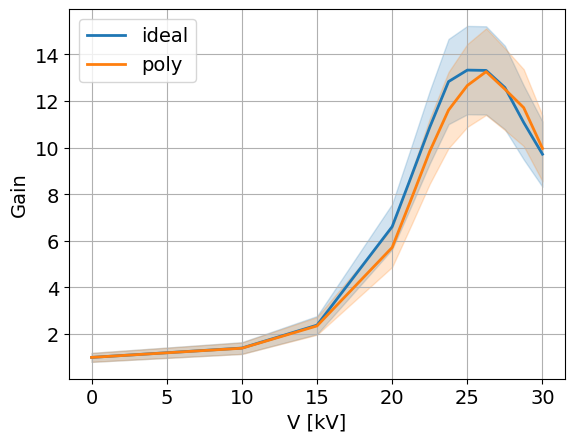

In [45]:
fig, ax = plt.subplots()

(l_ideal,) = ax.plot(voltages / 1e3, gains_ideal, lw=2, label="ideal")
ax.fill_between(
    voltages / 1e3,
    gains_ideal - 2 * gains_error_ideal,
    gains_ideal + 2 * gains_error_ideal,
    alpha=0.2,
    edgecolor=l_ideal.get_color(),
    facecolor=l_ideal.get_color(),
)

(l,) = ax.plot(voltages / 1e3, gains, lw=2, label="poly")
ax.fill_between(
    voltages / 1e3,
    gains - 2 * gains_error,
    gains + 2 * gains_error,
    alpha=0.2,
    edgecolor=l.get_color(),
    facecolor=l.get_color(),
)

ax.set_xlabel("V [kV]")
ax.set_ylabel("Gain")
ax.legend()
ax.grid()

### Velocity dependent detection efficiency

In [122]:
temperature = 6.3
rc_efficiency = 0.8
thermal_population = population.thermal_population(np.arange(4), temperature)

rc_population = (
    3 / 4 * thermal_population[0] + rc_efficiency * thermal_population[1:].sum()
)


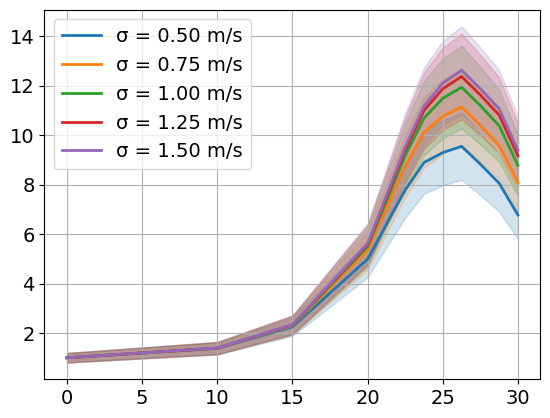

In [123]:
bins = np.linspace(-1.5, 1.5, 15)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

mu = 0
fig, ax = plt.subplots()

for sigma in np.linspace(0.5, 1.5, 5):
    gaussian = np.exp(-0.5 * ((bin_centers - mu) / sigma) ** 2)
    gaussian /= gaussian.sum()  # Normalize area under curve to 1
    dat_conv = []
    err_conv = []
    for voltage, datmF0, datmF2, datmF3 in zip(
        voltages, data["mF=0"], data["mF=2"], data["mF=3"]
    ):
        c0, v1 = datmF0[1].get_coordinates_velocities_at_position(z=5.184775)
        c2, v2 = datmF2[1].get_coordinates_velocities_at_position(z=5.184775)
        c3, v3 = datmF3[1].get_coordinates_velocities_at_position(z=5.184775)

        hist0 = np.histogram(v1.vx, bins=bins, density=False)[0]
        hist2 = np.histogram(v2.vx, bins=bins, density=False)[0]
        hist3 = np.histogram(v3.vx, bins=bins, density=False)[0]

        surv = (
            hist0 * rc_population
            + (hist2 + hist3)
            * (1 - rc_efficiency)
            * thermal_population[2]
            * 4
            / J2_levels
        )

        surv_err_squared = rc_population**2 * hist0 + (
            (1 - rc_efficiency) ** 2 * thermal_population[2] ** 2 * 16 / J2_levels**2
        ) * (hist2 + hist3)

        dat_conv.append((surv * gaussian).sum())
        err_conv.append(np.sqrt((gaussian**2 * surv_err_squared).sum()))

    dat_conv = np.array(dat_conv)
    err_conv = np.array(err_conv)

    g = dat_conv / dat_conv[0]
    ge = g * np.sqrt((err_conv / dat_conv) ** 2 + (err_conv[0] / dat_conv[0]) ** 2)

    (l,) = ax.plot(voltages / 1e3, g, lw=2, label=f"σ = {sigma:.2f} m/s")
    ax.fill_between(
        voltages / 1e3,
        g - 2 * ge,
        g + 2 * ge,
        alpha=0.2,
        edgecolor=l.get_color(),
        facecolor=l.get_color(),
    )

ax.legend()
ax.grid()


## mF=0, +/-1 only

In [46]:
nr_survived = survived["mF=0"].copy()
nr_survived_error = np.sqrt(nr_survived)
gains = nr_survived / nr_survived[0]
gains_error = gains * np.sqrt(1 / nr_survived + 1 / nr_survived[0])


In [47]:
print(f"{nr_survived=}")
print(f"{nr_survived_error=}")


nr_survived=array([ 206,  290,  494, 1210, 1645, 2088, 2464, 2688, 2814, 2654, 2485,
       2113])
nr_survived_error=array([14.35270009, 17.02938637, 22.22611077, 34.78505426, 40.55859958,
       45.69463864, 49.63869458, 51.84592559, 53.04714884, 51.51698749,
       49.84977432, 45.96737974])


In [48]:
print(f"{gains=}")
print(f"{gains_error=}")


gains=array([ 1.        ,  1.40776699,  2.39805825,  5.87378641,  7.98543689,
       10.13592233, 11.96116505, 13.04854369, 13.66019417, 12.88349515,
       12.0631068 , 10.25728155])
gains_error=array([0.09853293, 0.12827411, 0.19888941, 0.44271423, 0.59018114,
       0.74022053, 0.86751132, 0.94332874, 0.98597224, 0.93182133,
       0.87461962, 0.74868528])


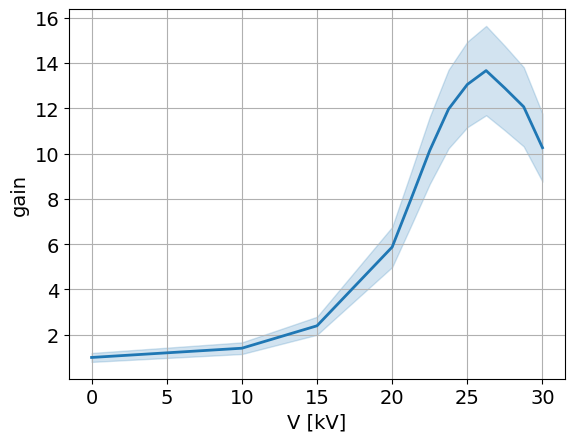

In [49]:
sl = np.s_[:]
fig, ax = plt.subplots()
(l,) = ax.plot(voltages / 1e3, gains, lw=2)
ax.fill_between(
    voltages / 1e3,
    gains - 2 * gains_error,
    gains + 2 * gains_error,
    alpha=0.2,
    edgecolor=l.get_color(),
    facecolor=l.get_color(),
)

ax.set_xlabel("V [kV]")
ax.set_ylabel("gain")
ax.grid()


### Velocity dependent detection efficiency

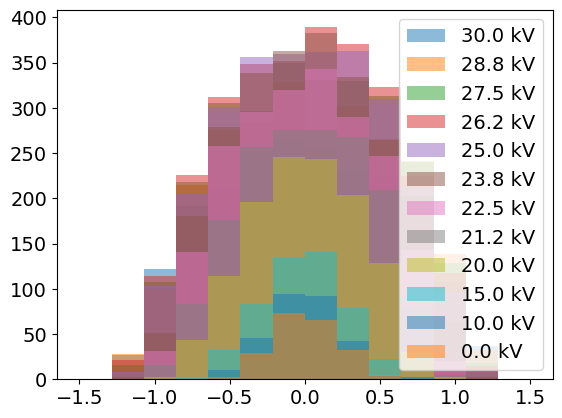

In [72]:
bins = np.linspace(-1.5, 1.5, 15)
bin_centers = 0.5 * (bins[:-1] + bins[1:])


fig, ax = plt.subplots()
for voltage, dat in zip(voltages[::-1], data["mF=0"][::-1]):
    c, v = dat[1].get_coordinates_velocities_at_position(z=5.184775)
    ax.hist(v.vx, label=f"{voltage / 1e3:.1f} kV", bins=bins, alpha=0.5)
ax.legend()


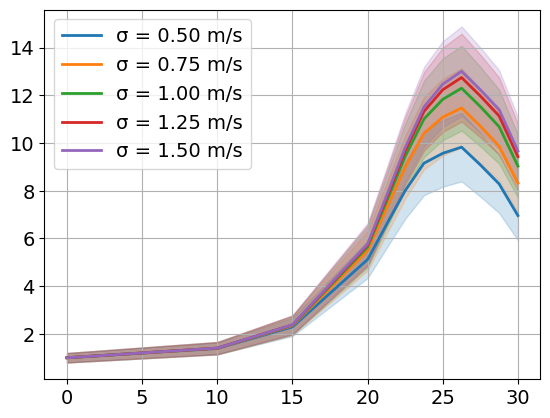

In [120]:
mu = 0
fig, ax = plt.subplots()

for sigma in np.linspace(0.5, 1.5, 5):
    gaussian = np.exp(-0.5 * ((bin_centers - mu) / sigma) ** 2)
    gaussian /= gaussian.sum()  # Normalize area under curve to 1
    dat_conv = []
    err_conv = []
    for voltage, dat in zip(voltages, data["mF=0"]):
        c, v = dat[1].get_coordinates_velocities_at_position(z=5.184775)
        hist = np.histogram(v.vx, bins=bins, density=False)[0]
        dat_conv.append((hist * gaussian).sum())
        err_conv.append(np.sqrt(np.sum((gaussian**2) * hist)))

    dat_conv = np.array(dat_conv)
    err_conv = np.array(err_conv)

    g = dat_conv / dat_conv[0]

    ge = g * np.sqrt((err_conv / dat_conv) ** 2 + (err_conv[0] / dat_conv[0]) ** 2)
    (l,) = ax.plot(voltages / 1e3, g, lw=2, label=f"σ = {sigma:.2f} m/s")
    ax.fill_between(
        voltages / 1e3,
        g - 2 * ge,
        g + 2 * ge,
        alpha=0.2,
        edgecolor=l.get_color(),
        facecolor=l.get_color(),
    )

ax.legend()
ax.grid()
